In [0]:
!pip install -q soundfile
import soundfile as sf
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import librosa
from librosa import display



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import numpy
import pandas as pd
from torch.optim import Adam

import time
import torch.nn.functional as F


directory='gdrive/My Drive/spoken/'




In [0]:
lene=0
label = []
for filename in os.listdir(directory):
    lene=lene+1
    label.append(filename[:2])

In [0]:
file = []
for filename in os.listdir(directory):
    file.append(filename)

**Reading Audio Files**

In [0]:
mel=[]
min=0.0
max=255.0
for i in range(lene):
  data, samplerate = sf.read(directory+file[i])
  mels =librosa.feature.melspectrogram(data, sr=samplerate)
  mels = numpy.log(mels + 1e-9)
  
  X_std = (mels - mels.min()) / (mels.max() - mels.min())*255
  


  img = X_std.astype(numpy.uint8)
  img = numpy.flip(img, axis=0) # put low frequencies at the bottom in image
  img = 255-img
  mel.append(img) 
  if(i%1000==0):
    print(i)



0


KeyboardInterrupt: ignored

In [0]:
from google.colab import files
import pickle
with open("spectrum.txt", "wb") as fp:   #Pickling
  pickle.dump(mel, fp)
 
files.download('spectrum.txt')

NameError: ignored

In [0]:
import pickle
with open("gdrive/My Drive/spectrum (1).txt", "rb") as fp:   # Unpickling
  b = pickle.load(fp)

In [0]:

data = {'filename':file,
        'language':label,
        'spectrum':b}
df = pd.DataFrame(data)
print(df.head())


                                            filename  ...                                           spectrum
0  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[147, 142, 142, 161, 162, 128, 122, 142, 176,...
1  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[137, 134, 134, 149, 149, 122, 118, 133, 160,...
2  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[136, 133, 132, 146, 148, 121, 116, 132, 159,...
3  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[165, 160, 160, 182, 183, 144, 137, 159, 196,...
4  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[158, 155, 155, 176, 175, 138, 132, 154, 189,...

[5 rows x 3 columns]


In [0]:
df=df.drop([1978,2026,3616])
df = df.reset_index(drop=True)

In [0]:
import sklearn
for i in range(50):
   df = sklearn.utils.shuffle(df)
df = df.reset_index(drop=True)
print(df.head())


                                            filename  ...                                           spectrum
0  en_f_5dff2b7b319207972450f91d569b5a16.fragment...  ...  [[177, 170, 158, 126, 118, 135, 164, 162, 177,...
1  de_f_9bd3b58fe6f75dc40e85021914b4b06a.fragment...  ...  [[177, 157, 155, 159, 175, 198, 190, 151, 141,...
2  es_f_7b894c491011d0d541a071d6637b8de1.fragment...  ...  [[173, 177, 196, 217, 163, 127, 116, 118, 129,...
3  de_f_6cc5c71681c0abc094a869e03b357384.fragment...  ...  [[188, 193, 190, 195, 215, 227, 219, 202, 189,...
4  en_f_31da456c78eb5cf86d2b447e2fbfb736.fragment...  ...  [[170, 175, 174, 194, 184, 166, 161, 167, 181,...

[5 rows x 3 columns]


In [0]:
df = pd.concat([df,pd.get_dummies(df['language'], prefix='lang')],axis=1)

In [0]:
def onehotcode(i):
  y=torch.tensor([df['lang_de'][i],df['lang_en'][i],df['lang_es'][i]])
  y=y.float()
  return y

**Batch Formation**

In [0]:
data=[]
output=[]
for i in range(0,10000,5):
  for j in range(i,i+5,1):
    if j%5 == 0:
      t=torch.tensor(df['spectrum'][j].reshape(1,1,128,313))
      y=onehotcode(j).reshape(1,3)
   
    else:
        t = torch.cat((torch.tensor(df['spectrum'][j].reshape(1,1,128,313)), t), 0)
        y=torch.cat((onehotcode(j).reshape(1,3),y),0)
  t=torch.tensor(t,dtype=torch.float32)
  data.append(t)
  output.append(y)
len(data)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


2000

**Neural Network Architecture**

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,size):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, size, 1, 1),
            nn.Dropout(0.2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=(2,2))
        )
        
        
        

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        
        
        
        return x
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conva = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=16,size=5),
        ) 
        self.convb = nn.Sequential(
            ConvBlock(in_channels=16, out_channels=32,size=5),
        )
        self.convc = nn.Sequential(
            ConvBlock(in_channels=32, out_channels=32,size=3),
            
        )
       
        self.rnn = nn.GRU(3456, 128, 1,batch_first=True)
        self.fc =  nn.Linear(128, 3)
           
        
        self.sig = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        hidden = self.init_hidden()
        
        x = self.conva(x)
        
        x = self.convb(x)
        
        x = self.convc(x)
        
        x = self.convc(x)
       
        
        
        x, hidden = self.rnn(x.view(5,1,3456),hidden)
        
        x=x.reshape(5,128)
        
        x=self.dropout(x)
        x = self.fc(x)
        
        x=self.sig(x)
        return x
    
    def init_hidden(self):
        
        hidden = torch.zeros(1,5,128)
        hidden=hidden.cuda()
        return hidden


**Training Details**

In [0]:
num_epochs = 10
   
    
lr = 1e-4
eta_min = 1e-5
t_max = 10

    
    
    
model = Classifier().cuda()
criterion = nn.BCELoss().cuda()
optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)



**Training Function**

In [0]:
a=[]
b=[]
for epoch in range(15):
    start_time = time.time()
    model.train()
    avg_loss = 0.
    z=0
    for i in range(1900):
            model.zero_grad()
            
            
            
            preds = model(data[i].cuda())
            
    
            loss = criterion(preds, output[i].cuda())
            
            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / 1900
            
            aprox = torch.round(preds.squeeze())
            aprox=aprox.cuda()
            for k in range(5):
              
                if torch.all(torch.eq(aprox[k], output[i].cuda()[k])):
                  z=z+1
            
    model.eval()
      
    
      
        
        
    

    if (epoch + 1) % 1 == 0:
        elapsed = time.time() - start_time
        print('Epoch :',epoch+1, ' avg_train_loss:' ,avg_loss ,  'time:' ,elapsed,'Training Accuracy:',z*100/(9500)  )
        a.append(avg_loss)
        
    l=0
    final=0
    m=0
    if (epoch+1) % 1 == 0:
      for j in range(1900,1950,1):
            l=l+1
            
            preds = model(data[j].cuda())
            
            y=output[j]
            y=y.cuda()
            loss = criterion(preds, y)
            final+=loss.item()/50
            aprox = torch.round(preds.squeeze())
            aprox=aprox.cuda()
            for k in range(5):
              
              if torch.all(torch.eq(aprox[k],y[k])):
                m=m+1
      
      
      print("Validation Loss :",final)
      print("Validation Accuracy :",(m*100)/(250),"%")
      b.append(final)

         
    

Epoch : 1  avg_train_loss: 0.5667993057558407 time: 16.083633184432983 Training Accuracy: 21.557894736842105
Validation Loss : 0.6063792455196381
Validation Accuracy : 26.8 %
Epoch : 2  avg_train_loss: 0.3596103182513465 time: 16.140400409698486 Training Accuracy: 67.36842105263158
Validation Loss : 0.42323504954576496
Validation Accuracy : 62.4 %
Epoch : 3  avg_train_loss: 0.19809654403085758 time: 16.16494584083557 Training Accuracy: 86.15789473684211
Validation Loss : 0.34263805761933325
Validation Accuracy : 71.6 %
Epoch : 4  avg_train_loss: 0.12175338113484359 time: 16.225072860717773 Training Accuracy: 91.8
Validation Loss : 0.22711893714964382
Validation Accuracy : 80.0 %
Epoch : 5  avg_train_loss: 0.08235753266827076 time: 16.44945764541626 Training Accuracy: 94.56842105263158
Validation Loss : 0.22276671238243578
Validation Accuracy : 79.6 %
Epoch : 6  avg_train_loss: 0.05640039651777211 time: 16.37003493309021 Training Accuracy: 96.27368421052631
Validation Loss : 0.210875630

**Training Loss And Validation Loss**

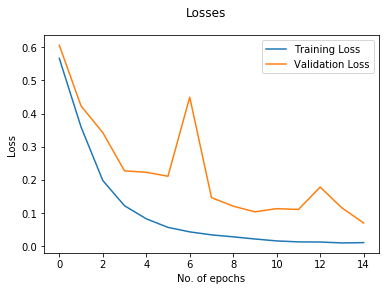

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(a)
plt.plot(b)
fig.suptitle('Losses')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')        
plt.legend(['Training Loss', 'Validation Loss'])

In [0]:
torch.cuda.memory_allocated()

0

**Testing **

In [0]:
model(data[1899].cuda())

AttributeError: ignored

In [0]:
net = torch.nn.DataParallel(model, device_ids=[0, 1, 2])
>>> output = net(input_var)

NameError: ignored

tensor([[3.7511e-04, 1.5445e-04, 9.9966e-01],
        [1.8104e-05, 9.9837e-01, 1.5176e-02],
        [1.6612e-03, 1.3944e-04, 9.9612e-01],
        [8.8973e-01, 4.4363e-04, 8.7098e-02],
        [2.7425e-05, 1.5278e-03, 9.9928e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [0]:
preds = model(data[1999].cuda())
            
aprox = torch.round(preds.squeeze())
print(aprox)
for l in range(5):
  print("For file",i*5)
  if aprox[l]==torch.tensor([0,0,1]).cuda():
    print('French')
  elif aprox[l]==torch.tensor([0,1,0].cuda()):
    print('English')
  else:
    print('German')

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
For file 49975


RuntimeError: ignored

In [0]:
df.head()

,filename,language,spectrum,lang_de,lang_en,lang_es
0,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...,de,"[[186, 183, 179, 187, 207, 225, 230, 233, 238,...",1,0,0
1,en_f_9a47e3d56398b8108f59385aab8bbe87.fragment...,en,"[[218, 221, 225, 229, 241, 236, 233, 236, 233,...",0,1,0
2,en_f_9a47e3d56398b8108f59385aab8bbe87.fragment...,en,"[[236, 228, 230, 235, 235, 235, 237, 240, 241,...",0,1,0
3,es_f_56ef0bde6c92a0100da23cdd39a8a112.fragment...,es,"[[202, 201, 200, 190, 194, 215, 231, 234, 210,...",0,0,1
4,de_f_26ddc4e756f61233d74d42cc000c9dae.fragment...,de,"[[139, 145, 168, 202, 217, 226, 213, 207, 213,...",1,0,0


In [0]:
data, samplerate = sf.read(directory+file[1])
mels =librosa.feature.melspectrogram(data, sr=samplerate)
mels = numpy.log(mels + 1e-9)
  
X_std = (mels - mels.min()) / (mels.max() - mels.min())*255
  


img = X_std.astype(numpy.uint8)
img = numpy.flip(img, axis=0) # put low frequencies at the bottom in image
img = 255-img
mel.append(img)

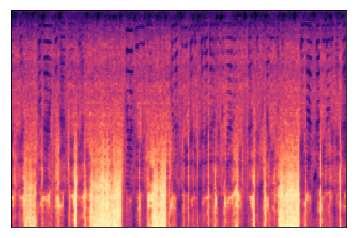

In [0]:
librosa.display.specshow(img)

In [0]:
cgb

Help on module matplotlib.pyplot in matplotlib:

NAME
    matplotlib.pyplot

DESCRIPTION
    `matplotlib.pyplot` is a state-based interface to matplotlib. It provides
    a MATLAB-like way of plotting.
    
    pyplot is mainly intended for interactive plots and simple cases of programmatic
    plot generation::
    
        import numpy as np
        import matplotlib.pyplot as plt
    
        x = np.arange(0, 5, 0.1)
        y = np.sin(x)
        plt.plot(x, y)
    
    The object-oriented API is recommended for more complex plots.

FUNCTIONS
    acorr(x, *, data=None, **kwargs)
        Plot the autocorrelation of *x*.
        
        Parameters
        ----------
        
        x : sequence of scalar
        
        detrend : callable, optional, default: `mlab.detrend_none`
            *x* is detrended by the *detrend* callable. Default is no
            normalization.
        
        normed : bool, optional, default: True
            If ``True``, input vectors are normalised 

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
